In [1]:
from utils import base_configs, deps, tr_va_te_split
from utils.helpers import dir_helpers, rw_csv_helpers, feature_distr_helpers

/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, math
import import_ipynb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# --- Helper: coerce a target column to numeric (tolerates common encodings) ---
def _coerce_target_numeric(s: pd.Series) -> pd.Series:
    # map common binaries; also treat 2 as 1 for yes/male-style fields
    mapping = {
        "Female":0,"female":0,"F":0,"f":0,"No":0,"no":0,"False":0,"false":0,"0":0, False:0, 0:0,
        "Male":1,"male":1,"M":1,"m":1,"Yes":1,"yes":1,"True":1,"true":1,"1":1, True:1, 1:1, 2:1,
        -9: np.nan
    }
    s2 = s.replace(mapping)
    return pd.to_numeric(s2, errors="coerce")

# --- 1) Calculate feature ↔ target correlation table ---
def calc_target_corr(df: pd.DataFrame, target_col: str, method: str = "pearson", top: int | None = None) -> pd.DataFrame:
    """
    Returns a DataFrame with columns: ['Feature', 'Correlation'], sorted by |Correlation| desc.
    Only numeric features are considered; target is coerced to numeric (common encodings handled).
    """
    if target_col not in df.columns:
        raise KeyError(f"Target '{target_col}' not found in df.")
    # coerce target & numeric-only features
    df = df.copy()
    df[target_col] = _coerce_target_numeric(df[target_col])
    num = df.select_dtypes(include="number")
    if target_col not in num.columns:
        raise KeyError(f"Target '{target_col}' must be numeric after coercion.")
    if num.shape[1] <= 1:
        raise ValueError("No numeric features to correlate with the target.")

    # compute correlations against target; drop the target itself
    corr_s = num.corr(method=method)[target_col].drop(labels=[target_col])
    corr_df = corr_s.reindex(corr_s.abs().sort_values(ascending=False).index) \
                    .to_frame("Correlation").reset_index()
    corr_df.rename(columns={"index": "Feature"}, inplace=True)
    return corr_df.head(top) if top else corr_df

# --- 2) (Optional) Quick plot of the correlations (matplotlib only) ---
def plot_target_corr(corr_df: pd.DataFrame, target_col: str, title: str | None = None):
    """
    Horizontal bar plot for the correlation table returned by calc_target_corr().
    """
    if corr_df.empty:
        raise ValueError("corr_df is empty.")
    y = np.arange(len(corr_df))
    vals = corr_df["Correlation"].values
    labels = corr_df["Feature"].astype(str).values

    plt.figure(figsize=(8, max(3, 0.35*len(corr_df))))
    bars = plt.barh(y, vals, edgecolor="black")
    # color-code by sign (optional)
    for i, b in enumerate(bars):
        b.set_facecolor("#4c9aff" if vals[i] >= 0 else "#ff6b6b")

    plt.yticks(y, labels)
    plt.xlabel("Correlation")
    plt.title(title or f"Correlation with '{target_col}'")
    plt.axvline(0, linestyle="--", linewidth=1, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [4]:
# ============================================
# Questionnaire utilities (calc + optional plot)
# ============================================
from __future__ import annotations
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches

# ---------------------------
# 0) Small helpers
# ---------------------------
def _build_alias(alias_or_fn) -> dict:
    """Return a flat {original: alias} dict from a dict or a provider function."""
    if alias_or_fn is None:
        return {}
    if callable(alias_or_fn):
        nested = alias_or_fn()  # expect {category: {orig: alias}}
        return {k: v for cat in nested.values() for k, v in cat.items()}
    return dict(alias_or_fn)

def _to_alias(name: str, alias: dict) -> str:
    """Return display alias for a variable name (idempotent if already alias)."""
    if name in alias:
        return alias[name]
    if name in alias.values():
        return name
    return name

def _is_strict_binary(series: pd.Series) -> bool:
    s = series.dropna()
    if s.empty:
        return False
    # normalize common types
    def _norm(v):
        if isinstance(v, (bool, np.bool_)):
            return int(v)
        # allow numeric strings "0"/"1"
        if isinstance(v, str) and v.strip() in {"0", "1"}:
            return int(v.strip())
        return v
    vals = set(map(_norm, s.unique()))
    return vals.issubset({0, 1}) and len(vals) > 0

def _is_integer_like_numeric(series: pd.Series, tol: float = 1e-9) -> bool:
    if not pd.api.types.is_numeric_dtype(series):
        return False
    s_num = pd.to_numeric(series, errors="coerce").dropna().values
    if s_num.size == 0:
        return False
    return np.all(np.isfinite(s_num)) and np.all(np.abs(s_num - np.round(s_num)) <= tol)

def _nice_step(span: float) -> float:
    if span <= 0 or not np.isfinite(span):
        return 1.0
    raw = span / 6.0
    exp = math.floor(math.log10(raw))
    frac = raw / (10 ** exp)
    if frac < 1.5:   nice = 1.0
    elif frac < 3:   nice = 2.0
    elif frac < 7:   nice = 5.0
    else:            nice = 10.0
    return nice * (10 ** exp)

def _recode_known_binaries(df: pd.DataFrame, alias: dict) -> pd.DataFrame:
    """
    Recode known binary columns to {0,1} so they pass _is_strict_binary.
    - Biological sex variants: 0=Female, 1=Male (also maps 2->1)
    - Also maps Yes/No to 1/0 if encountered.
    """
    out = df.copy()

    def _candidates(bases):
        names = set(bases)
        for n in bases:
            names.add(_to_alias(n, alias))
        # common display variant
        names.add("Biological Sex")
        return [c for c in names if c in out.columns]

    # sex
    sex_cols = _candidates(["BirthGender", "BiologicalSex", "Sex"])
    if sex_cols:
        sex_map = {
            "Female": 0, "female": 0, "F": 0, "f": 0, 0: 0, False: 0,
            "Male": 1,   "male": 1,   "M": 1, "m": 1, 1: 1, 2: 1, True: 1,
            "No": 0, "no": 0, "Yes": 1, "yes": 1, "0": 0, "1": 1,
        }
        for col in sex_cols:
            out[col] = out[col].replace(sex_map)
            # coerce any "0"/"1" strings
            out[col] = pd.to_numeric(out[col], errors="ignore")

    return out

# ---------------------------
# 1) PREP / CALC (no plotting)
# ---------------------------
def prepare_questionnaire(
    df: pd.DataFrame,
    alias_or_fn=None,
    overrides: dict | None = None,
    cat_cutoff: int = 10,
) -> dict:
    """
    Clean df (-9->NaN), apply aliases, recode known binaries, partition variables,
    and compute binary counts. Returns a 'prep' dict.
    """
    alias = _build_alias(alias_or_fn)
    df2 = df.replace(-9, np.nan).rename(columns={c: alias.get(c, c) for c in df.columns})

    # Recode known binaries (ensures Biological Sex is {0,1})
    df2 = _recode_known_binaries(df2, alias)

    # Default per-variable overrides (can be augmented/replaced by 'overrides')
    base_labels = {
        "FreqGoProvider": {
            "title": "Participants with " + _to_alias("FreqGoProvider", alias),
            "x":     _to_alias("FreqGoProvider", alias),
            "y":     "Number of Participants",
            "xlim":  (df2[_to_alias("FreqGoProvider", alias)].min(), df2[_to_alias("FreqGoProvider", alias)].max()),
            "xticks_interval": 2,
        },
        '''
        "AverageSleepNight": {
            "title": "Participants with " + _to_alias("AverageSleepNight", alias),
            "x":     _to_alias("AverageSleepNight", alias),
            "y":     "Number of Participants",
            "xlim":  (df2[_to_alias("AverageSleepNight", alias)].min(), df2[_to_alias("AverageSleepNight", alias)].max()),
            "xticks_interval": 2,
        },
        '''
        "AverageTimeSitting": {
            "title": "Participants with " + _to_alias("AverageTimeSitting", alias),
            "x":     _to_alias("AverageTimeSitting", alias),
            "y":     "Number of Participants",
            "xlim":  (df2[_to_alias("AverageTimeSitting", alias)].min(), df2[_to_alias("AverageTimeSitting", alias)].max()),
            "xticks_interval": 2,
        },
        "Age": {
            "title": "Participants with " + _to_alias("Age", alias),
            "x":     _to_alias("Age", alias),
            "y":     "Number of Participants",
            "xlim":  (df2[_to_alias("Age", alias)].min(), df2[_to_alias("Age", alias)].max()),
            "xticks_interval": 10,
        },
        "BMI": {
            "title": "Participants with " + _to_alias("BMI", alias),
            "x":     _to_alias("BMI", alias),
            "y":     "Number of Participants",
            "xlim":  (14, 70),
            "xticks_interval": 14,
        },
        "PHQ4": {
            "title": "Participants with " + _to_alias("PHQ4", alias),
            "x":     _to_alias("PHQ4", alias),
            "y":     "Number of Participants",
            "xlim":  (df2[_to_alias("PHQ4", alias)].min(), df2[_to_alias("PHQ4", alias)].max()),
            "xticks_interval": 5,
        },
        "WeeklyMinutesModerateExercise": {
            "title": "Participants with " + _to_alias("WeeklyMinutesModerateExercise", alias),
            "x":     _to_alias("WeeklyMinutesModerateExercise", alias),
            "y":     "Number of Participants",
            # xlim set to [0, q99] in plot
            "xticks_interval": 200,
        },
        "AvgDrinksPerWeek": {
            "title": "Participants with " + _to_alias("AvgDrinksPerWeek", alias),
            "x":     _to_alias("AvgDrinksPerWeek", alias),
            "y":     "Number of Participants",
            # xlim set to [0, ceil(q99)] in plot
            "xticks_interval": 5,
        },
    }
    overrides = overrides or {}
    plot_labels = {**base_labels, **overrides}

    # Mirror overrides onto alias strings too (if provided under originals)
    for orig, al in alias.items():
        if orig in plot_labels and al not in plot_labels:
            plot_labels[al] = plot_labels[orig]

    # Partition variables
    binary_vars = [c for c in df2.columns if _is_strict_binary(df2[c])]
    nonbinary_vars = [c for c in df2.columns if c not in binary_vars]

    # Sort binary by count of 1s desc
    counts0 = [(df2[c] == 0).sum() for c in binary_vars]
    counts1 = [(df2[c] == 1).sum() for c in binary_vars]
    order = np.argsort(-np.array(counts1))
    binary_sorted = [binary_vars[i] for i in order]
    counts0_sorted = [counts0[i] for i in order]
    counts1_sorted = [counts1[i] for i in order]

    # Special aliases used in plot logic
    alias_minutes = _to_alias("WeeklyMinutesModerateExercise", alias)
    alias_drinks  = _to_alias("AvgDrinksPerWeek", alias)

    return {
        "df": df2,
        "alias": alias,
        "plot_labels": plot_labels,
        "binary_vars": binary_vars,
        "nonbinary_vars": nonbinary_vars,
        "binary_sorted": binary_sorted,
        "counts0_sorted": counts0_sorted,
        "counts1_sorted": counts1_sorted,
        "specials": (alias_minutes, alias_drinks),
        "cat_cutoff": cat_cutoff,
    }

def get_axis_labels(col: str, prep: dict):
    """Resolve title/x/y + raw override dict for a column using prep['plot_labels']."""
    alias = prep["alias"]
    to_alias = lambda n: _to_alias(n, alias)
    plot_labels = prep["plot_labels"]

    override = plot_labels.get(col, {})
    title_label = override.get("title", to_alias(col))
    x_label     = override.get("x", to_alias(col))
    y_label     = override.get("y")
    return title_label, x_label, y_label, override

# ---------------------------
# 2) OPTIONAL PLOTS
# ---------------------------
def plot_binary_overview(
    prep: dict,
    sex_keys: tuple[str, ...] = ("BirthGender", "BiologicalSex", "Sex"),
    title: str = "Participant Distributions on Binary Questionnaire"
):
    """Horizontal grouped bars for 0/1, with optional custom legend for sex."""
    df = prep["df"]
    binary_sorted = prep["binary_sorted"]
    c0 = prep["counts0_sorted"]
    c1 = prep["counts1_sorted"]

    if not binary_sorted:
        return

    y = np.arange(len(binary_sorted))
    h = 0.4
    fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * len(binary_sorted))))
    bars0 = ax.barh(y - h/2, c0, height=h, edgecolor="black", label="0")
    bars1 = ax.barh(y + h/2, c1, height=h, edgecolor="black", label="1")

    ax.set_xlabel("Number of Participants")
    ax.set_ylabel("Binary Questionnaire Variables")
    ax.set_yticks(y)
    ax.set_yticklabels([get_axis_labels(var, prep)[0] for var in binary_sorted])
    ax.set_title(title)

    # Sex legend if a sex var is present (check raw names, their aliases, and common display)
    alias = prep["alias"]
    to_alias = lambda n: _to_alias(n, alias)
    possible = set(sex_keys) | {to_alias(k) for k in sex_keys} | {"Biological Sex"}
    if any(name in binary_sorted for name in possible):
        female_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(), edgecolor="black", label="0 = Female")
        male_patch   = mpatches.Patch(facecolor=bars1[0].get_facecolor(), edgecolor="black", label="1 = Male")
        leg2 = ax.legend(handles=[female_patch, male_patch],
                         title="Biological Sex",
                         loc="lower right", bbox_to_anchor=(0.98, 0.10),
                         bbox_transform=ax.transAxes,
                         borderaxespad=0.0, frameon=True, fancybox=False,
                         borderpad=0.2, handlelength=1.2, handletextpad=0.4, labelspacing=0.3)
        ax.add_artist(leg2)

    # Generic Yes/No legend
    yes_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(), edgecolor="black", label="0 = No")
    no_patch  = mpatches.Patch(facecolor=bars1[0].get_facecolor(), edgecolor="black", label="1 = Yes")
    ax.legend(handles=[yes_patch, no_patch],
              title="Value",
              loc="lower right", bbox_to_anchor=(0.98, 0.19),
              bbox_transform=ax.transAxes,
              borderaxespad=0.0, frameon=True, fancybox=False,
              borderpad=0.2, handlelength=1.2, handletextpad=0.4, labelspacing=0.3)

    ax.set_xlim(0, max(max(c0 or [0]), max(c1 or [0])) * 1.01)
    ax.margins(x=0)
    plt.tight_layout()
    plt.show()

def plot_nonbinary_grid(
    prep: dict,
    ncols: int = 4,
    grid_title: str = "Participant Distributions on Non-binary Questionnaire"
):
    """Grid of histograms/bar charts for non-binary vars with special cases."""
    df = prep["df"]
    nb = prep["nonbinary_vars"]
    if not nb:
        return

    alias_minutes, alias_drinks = prep["specials"]
    cat_cutoff = prep["cat_cutoff"]

    n = len(nb)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(nb):
        ax = axes[i]
        s = df[col].dropna()
        title_label, x_label, y_label, override = get_axis_labels(col, prep)
        if y_label is None:
            y_label = "Number of Participants"

        numeric_dtype = pd.api.types.is_numeric_dtype(s)
        integer_like  = _is_integer_like_numeric(s)

        if (not numeric_dtype) or (s.nunique() <= cat_cutoff and not integer_like):
            counts = s.astype(str).value_counts(dropna=False).sort_index()
            ax.bar(counts.index, counts.values, width=1.0, edgecolor="black")

            if "xlim" in override:
                ax.set_xlim(*override["xlim"])
            if "xticks_interval" in override and "xlim" in override:
                start, end = override["xlim"]
                step = override["xticks_interval"]
                if step and step > 0:
                    ax.set_xticks(np.arange(start, end + step, step))

        else:
            s_num = pd.to_numeric(s, errors="coerce").dropna()

            # --- SPECIAL CASE 1: WeeklyMinutesModerateExercise ---
            if col == alias_minutes:
                q99 = float(np.nanpercentile(s_num, 99))
                q99 = max(q99, 0.0)
                edges = np.arange(0.0, q99 + 30.0, 30.0)
                if edges.size < 2:
                    edges = 20
                ax.hist(s_num, bins=edges, edgecolor="black")
                ax.set_xlim(0.0, q99)
                step = override.get("xticks_interval", 50)
                if step and step > 0:
                    ax.set_xticks(np.arange(0.0, q99 + step, step))

            # --- SPECIAL CASE 2: AvgDrinksPerWeek ---
            elif col == alias_drinks:
                q99 = float(np.nanpercentile(s_num, 99))
                xmax_i = int(max(0, math.ceil(q99)))
                xmin_i = 0
                bin_edges = np.arange(xmin_i - 0.5, xmax_i + 1.5, 1.0)
                if bin_edges.size < 2:
                    bin_edges = 20
                ax.hist(s_num, bins=bin_edges, edgecolor="black")
                ax.set_xlim(xmin_i - 0.5, xmax_i + 0.5)
                step = override.get("xticks_interval", 2)
                step = step if step and step > 0 else 1
                ax.set_xticks(np.arange(xmin_i, xmax_i + 1, step))

            # --- DEFAULT NUMERIC HANDLING ---
            else:
                if integer_like:
                    xmin = int(np.floor(s_num.min()))
                    xmax = int(np.ceil(s_num.max()))
                    if "xlim" in override:
                        xmin, xmax = int(override["xlim"][0]), int(override["xlim"][1])
                    bin_edges = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
                    ax.hist(s_num, bins=bin_edges, edgecolor="black")
                    ax.set_xlim(xmin - 0.5, xmax + 0.5)
                    step = override.get("xticks_interval", 1)
                    step = step if step and step > 0 else 1
                    ax.set_xticks(np.arange(xmin, xmax + 1, step))
                else:
                    bins = int(override.get("bins", 20))
                    ax.hist(s_num, bins=bins, edgecolor="black")
                    if "xlim" in override:
                        xmin, xmax = override["xlim"]
                        ax.set_xlim(xmin, xmax)
                        step = override.get("xticks_interval", None)
                        if step and step > 0:
                            ax.xaxis.set_major_locator(MultipleLocator(step))
                            ax.set_xticks(np.arange(xmin, xmax + step, step))
                    else:
                        xmin, xmax = float(s_num.min()), float(s_num.max())
                        span = xmax - xmin
                        step = override.get("xticks_interval", None)
                        if step is None:
                            step = _nice_step(span)
                        ax.xaxis.set_major_locator(MultipleLocator(step))

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

        if "ylim" in override:
            ax.set_ylim(*override["ylim"])
        if "xscale" in override:
            ax.set_xscale(override["xscale"])
        if "yscale" in override:
            ax.set_yscale(override["yscale"])

    # Remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(grid_title, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


### 0 Data load

In [5]:
df_hints6 = "ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv"
df_hints7 = "ip/3_cleanedEncoded/....csv"
df_hints6_7 = "ip/3_cleanedEncoded/hints6_7_cleaned_encoded.csv"
df_orig = rw_csv_helpers.read_csv_file(df_hints6, verbose = 1)

Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (4865, 27)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageSleepNight', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [6]:
counts = feature_distr_helpers.count01(df_orig.copy(), "MedConditions_HeartCondition", verbose=1)

Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64
Total (0/1 only): 4865


### 1 Correlation matrix

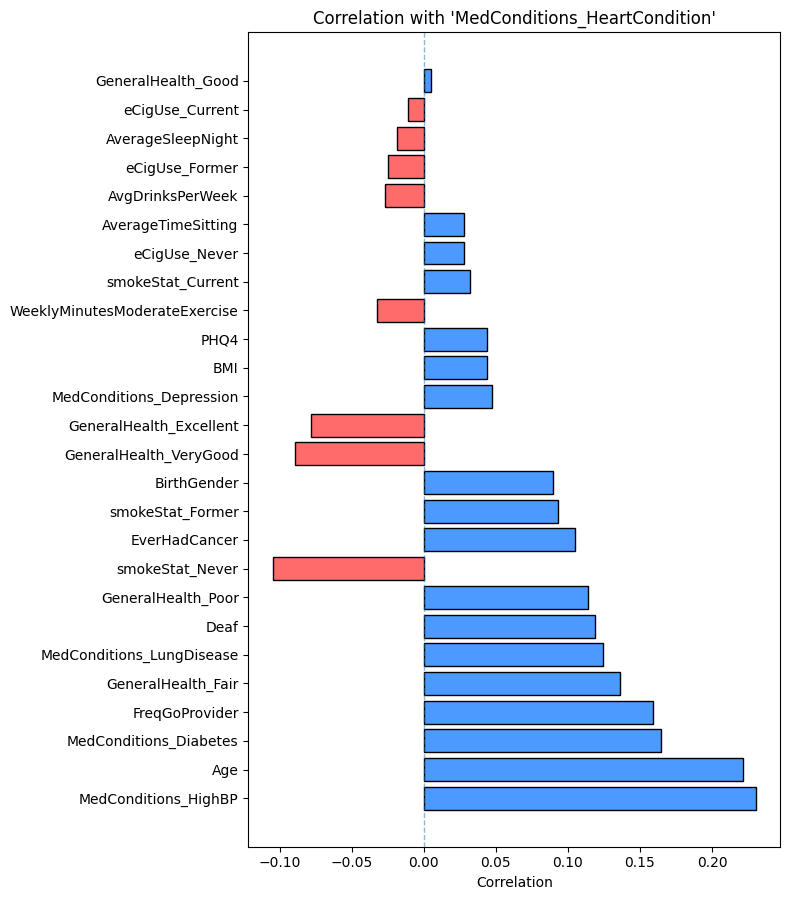

In [7]:
target_col = "MedConditions_HeartCondition"
corr_df = calc_target_corr(df_orig.copy(), target_col, top=30)   # or None for all
plot_target_corr(corr_df, target_col)

/tmp/ipykernel_33338/2309593561.py:94: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  out[col] = pd.to_numeric(out[col], errors="ignore")


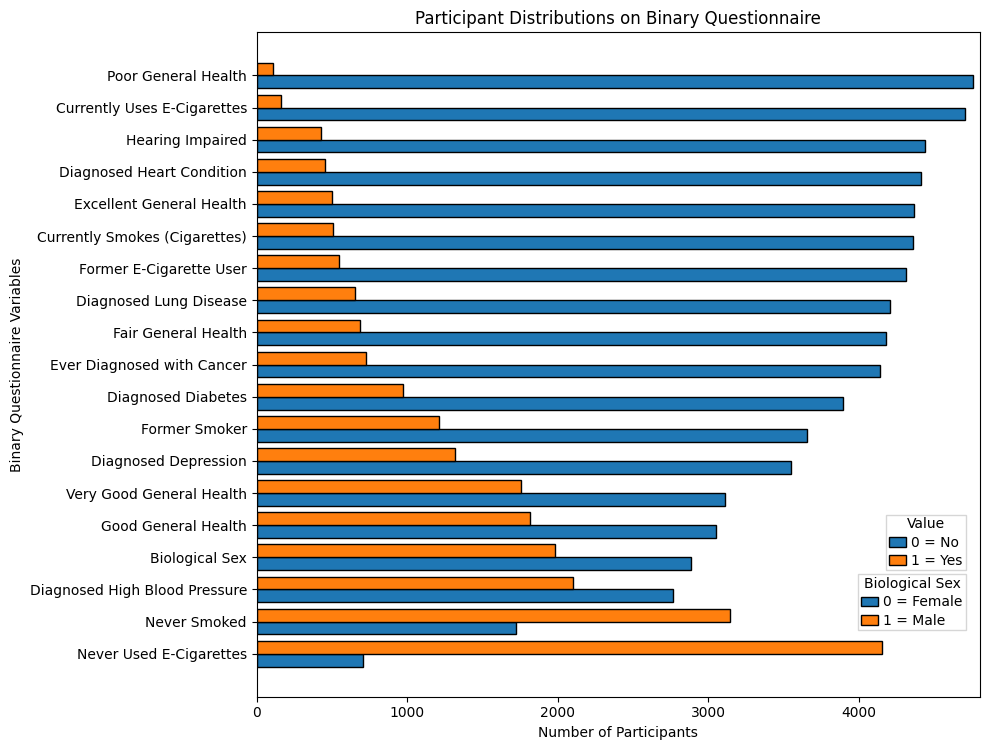

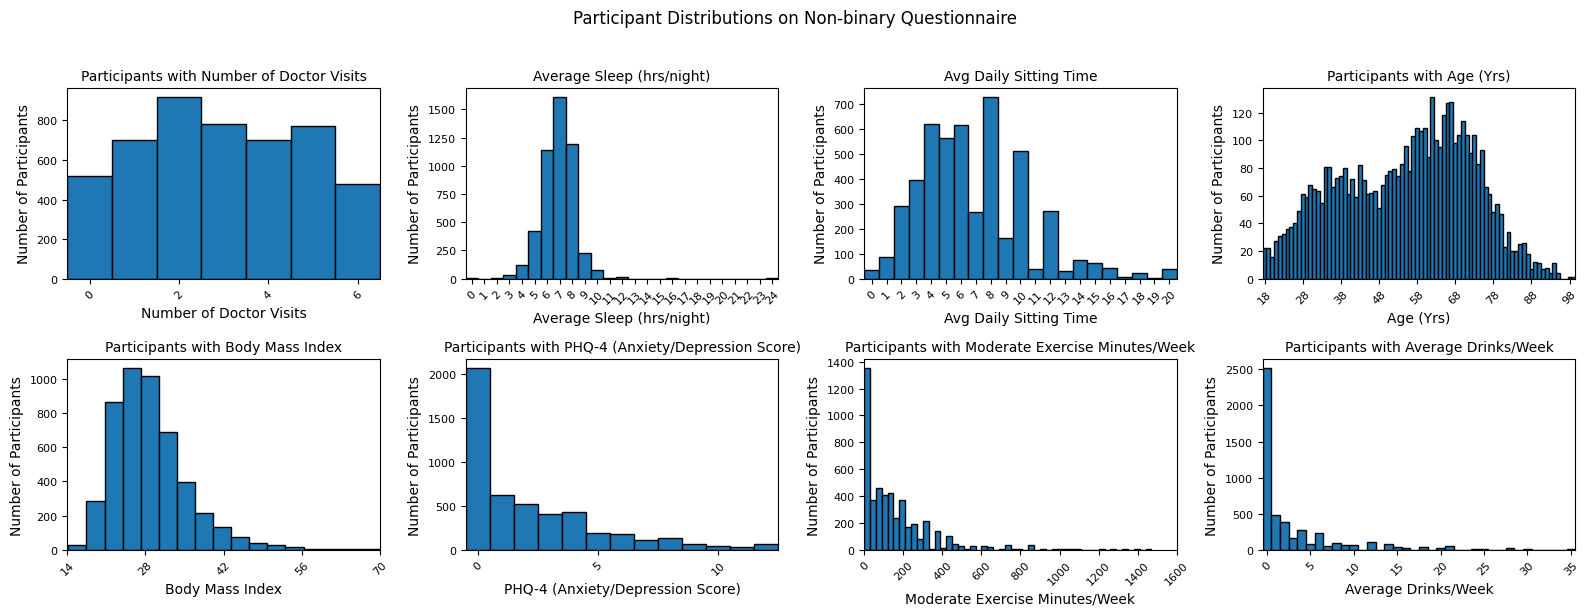

In [8]:
# Flatten alias dictionary: original_var_name -> alias
alias_dict = {k: v for cat in feature_distr_helpers.get_feature_alias_by_category().values() for k, v in cat.items()}

prep = prepare_questionnaire(df_orig.copy(), alias_or_fn=alias_dict, overrides=None, cat_cutoff=10)

plot_binary_overview(prep)
plot_nonbinary_grid(prep, ncols=4)

### 3 Save resulting data

In [9]:
# ============================================
# EXPORT HELPERS (figures + CSVs)
# ============================================
import os
from pathlib import Path

def _ensure_dir(p):
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

def _sanitize(name: str) -> str:
    return "".join(ch if ch.isalnum() or ch in ("-","_") else "_" for ch in str(name)).strip("_")

# ---------- 1) DATA EXPORTS ----------
def export_binary_summary_csv(prep: dict, csv_path: str | Path) -> str:
    """Save counts used in the binary overview plot."""
    import pandas as pd
    vars_ = prep["binary_sorted"]
    c0    = prep["counts0_sorted"]
    c1    = prep["counts1_sorted"]
    df = pd.DataFrame({
        "variable": vars_,
        "label":    [get_axis_labels(v, prep)[0] for v in vars_],
        "count_0":  c0,
        "count_1":  c1,
        "total":    [a+b for a,b in zip(c0, c1)],
        "pct_1":    [ (b/(a+b))*100 if (a+b)>0 else 0.0 for a,b in zip(c0, c1) ],
        "pct_0":    [ (a/(a+b))*100 if (a+b)>0 else 0.0 for a,b in zip(c0, c1) ],
    })
    csv_path = str(csv_path)
    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(csv_path, index=False)
    return csv_path

def export_nonbinary_distributions_csvs(
    prep: dict,
    out_dir: str | Path,
) -> dict:
    """
    For each non-binary variable:
      - If treated as categorical: export value counts
      - If numeric: export histogram counts + bin edges per your plotting rules
    Returns: dict {column_name: csv_path}; also writes a manifest.csv in out_dir.
    """
    import numpy as np
    import pandas as pd
    from matplotlib.ticker import MultipleLocator

    out_dir = _ensure_dir(out_dir)
    df = prep["df"]
    nb = prep["nonbinary_vars"]
    alias_minutes, alias_drinks = prep["specials"]
    cat_cutoff = prep["cat_cutoff"]

    paths = {}
    manifest_rows = []

    for col in nb:
        s = df[col].dropna()
        title_label, x_label, y_label, override = get_axis_labels(col, prep)
        numeric_dtype = pd.api.types.is_numeric_dtype(s)
        integer_like  = _is_integer_like_numeric(s)

        csv_name = f"{_sanitize(col)}.csv"
        csv_path = out_dir / csv_name

        # Categorical (or low-cardinality non-integer numerics)
        if (not numeric_dtype) or (s.nunique() <= cat_cutoff and not integer_like):
            counts = s.astype(str).value_counts(dropna=False).sort_index()
            pd.DataFrame({"category": counts.index, "count": counts.values}).to_csv(csv_path, index=False)
            kind = "categorical"

        else:
            # Numeric -> histogram
            s_num = pd.to_numeric(s, errors="coerce").dropna()

            if col == alias_minutes:
                q99 = float(np.nanpercentile(s_num, 99))
                q99 = max(q99, 0.0)
                edges = np.arange(0.0, q99 + 30.0, 30.0)
                if edges.size < 2:
                    # fallback number of bins
                    counts, edges = np.histogram(s_num, bins=20)
                else:
                    counts, _ = np.histogram(s_num, bins=edges)
                kind = "hist_minutes"
            elif col == alias_drinks:
                q99 = float(np.nanpercentile(s_num, 99))
                xmax_i = int(max(0, math.ceil(q99)))
                xmin_i = 0
                edges = np.arange(xmin_i - 0.5, xmax_i + 1.5, 1.0)
                if edges.size < 2:
                    counts, edges = np.histogram(s_num, bins=20)
                else:
                    counts, _ = np.histogram(s_num, bins=edges)
                kind = "hist_drinks_int"
            else:
                if integer_like:
                    xmin = int(np.floor(s_num.min()))
                    xmax = int(np.ceil(s_num.max()))
                    if "xlim" in override:
                        xmin, xmax = int(override["xlim"][0]), int(override["xlim"][1])
                    edges = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
                    if edges.size < 2:
                        counts, edges = np.histogram(s_num, bins=20)
                    else:
                        counts, _ = np.histogram(s_num, bins=edges)
                    kind = "hist_integer_like"
                else:
                    bins = int(override.get("bins", 20))
                    counts, edges = np.histogram(s_num, bins=bins)
                    kind = "hist_continuous"

            # Save edges + counts
            centers = (edges[:-1] + edges[1:]) / 2.0
            pd.DataFrame({
                "bin_left":  edges[:-1],
                "bin_right": edges[1:],
                "bin_center": centers,
                "count":     counts,
            }).to_csv(csv_path, index=False)

        paths[col] = str(csv_path)
        manifest_rows.append({
            "column": col,
            "label": title_label,
            "type": kind if (numeric_dtype or (s.nunique() <= cat_cutoff and not integer_like)) else "categorical",
            "csv_path": str(csv_path),
        })

    # Manifest
    manifest = pd.DataFrame(manifest_rows)
    manifest_path = out_dir / "manifest.csv"
    manifest.to_csv(manifest_path, index=False)
    paths["_manifest"] = str(manifest_path)
    return paths

# ---------- 2) FIGURE EXPORTS ----------
def plot_binary_overview_save(
    prep: dict,
    save_path: str | Path,
    dpi: int = 200,
    show: bool = False,  # default to not showing during batch export
):
    """Save the binary overview figure."""
    # Reuse your plotter but intercept the display
    df = prep["df"]
    binary_sorted = prep["binary_sorted"]
    c0 = prep["counts0_sorted"]
    c1 = prep["counts1_sorted"]
    if not binary_sorted:
        return None

    y = np.arange(len(binary_sorted))
    h = 0.4
    fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * len(binary_sorted))))
    bars0 = ax.barh(y - h/2, c0, height=h, edgecolor="black", label="0")
    bars1 = ax.barh(y + h/2, c1, height=h, edgecolor="black", label="1")

    ax.set_xlabel("Number of Participants")
    ax.set_ylabel("Binary Questionnaire Variables")
    ax.set_yticks(y)
    ax.set_yticklabels([get_axis_labels(var, prep)[0] for var in binary_sorted])
    ax.set_title("Participant Distributions on Binary Questionnaire")

    # Legends (same logic as your function)
    alias = prep["alias"]
    to_alias = lambda n: _to_alias(n, alias)
    possible = {"BirthGender", "BiologicalSex", "Sex"} | {to_alias(k) for k in ("BirthGender","BiologicalSex","Sex")} | {"Biological Sex"}
    if any(name in binary_sorted for name in possible):
        female_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(), edgecolor="black", label="0 = Female")
        male_patch   = mpatches.Patch(facecolor=bars1[0].get_facecolor(), edgecolor="black", label="1 = Male")
        leg2 = ax.legend(handles=[female_patch, male_patch],
                         title="Biological Sex",
                         loc="lower right", bbox_to_anchor=(0.98, 0.10),
                         bbox_transform=ax.transAxes,
                         borderaxespad=0.0, frameon=True, fancybox=False,
                         borderpad=0.2, handlelength=1.2, handletextpad=0.4, labelspacing=0.3)
        ax.add_artist(leg2)

    yes_patch = mpatches.Patch(facecolor=bars0[0].get_facecolor(), edgecolor="black", label="0 = No")
    no_patch  = mpatches.Patch(facecolor=bars1[0].get_facecolor(), edgecolor="black", label="1 = Yes")
    ax.legend(handles=[yes_patch, no_patch],
              title="Value",
              loc="lower right", bbox_to_anchor=(0.98, 0.19),
              bbox_transform=ax.transAxes)

    ax.set_xlim(0, max(max(c0 or [0]), max(c1 or [0])) * 1.01)
    ax.margins(x=0)
    plt.tight_layout()

    save_path = str(save_path)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    return save_path

def plot_nonbinary_grid_save(
    prep: dict,
    save_path: str | Path,
    ncols: int = 4,
    dpi: int = 200,
    show: bool = False,
):
    """Save the non-binary grid figure."""
    # reuse your plotting logic (no CSV here; use export_nonbinary_distributions_csvs for data)
    df = prep["df"]
    nb = prep["nonbinary_vars"]
    if not nb:
        return None

    alias_minutes, alias_drinks = prep["specials"]
    cat_cutoff = prep["cat_cutoff"]

    n = len(nb)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(nb):
        ax = axes[i]
        s = df[col].dropna()
        title_label, x_label, y_label, override = get_axis_labels(col, prep)
        if y_label is None:
            y_label = "Number of Participants"

        numeric_dtype = pd.api.types.is_numeric_dtype(s)
        integer_like  = _is_integer_like_numeric(s)

        if (not numeric_dtype) or (s.nunique() <= cat_cutoff and not integer_like):
            counts = s.astype(str).value_counts(dropna=False).sort_index()
            ax.bar(counts.index, counts.values, width=1.0, edgecolor="black")
            if "xlim" in override:
                ax.set_xlim(*override["xlim"])
            if "xticks_interval" in override and "xlim" in override:
                start, end = override["xlim"]; step = override["xticks_interval"]
                if step and step > 0:
                    ax.set_xticks(np.arange(start, end + step, step))
        else:
            s_num = pd.to_numeric(s, errors="coerce").dropna()
            if col == alias_minutes:
                q99 = float(np.nanpercentile(s_num, 99)); q99 = max(q99, 0.0)
                edges = np.arange(0.0, q99 + 30.0, 30.0)
                if edges.size < 2: edges = 20
                ax.hist(s_num, bins=edges, edgecolor="black")
                ax.set_xlim(0.0, q99)
                step = prep["plot_labels"].get(col, {}).get("xticks_interval", 50)
                if step and step > 0: ax.set_xticks(np.arange(0.0, q99 + step, step))
            elif col == alias_drinks:
                q99 = float(np.nanpercentile(s_num, 99))
                xmax_i = int(max(0, math.ceil(q99))); xmin_i = 0
                edges = np.arange(xmin_i - 0.5, xmax_i + 1.5, 1.0)
                if edges.size < 2: edges = 20
                ax.hist(s_num, bins=edges, edgecolor="black")
                ax.set_xlim(xmin_i - 0.5, xmax_i + 0.5)
                step = prep["plot_labels"].get(col, {}).get("xticks_interval", 2) or 1
                ax.set_xticks(np.arange(xmin_i, xmax_i + 1, step))
            else:
                if integer_like:
                    xmin = int(np.floor(s_num.min())); xmax = int(np.ceil(s_num.max()))
                    if "xlim" in override: xmin, xmax = int(override["xlim"][0]), int(override["xlim"][1])
                    edges = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
                    ax.hist(s_num, bins=edges, edgecolor="black")
                    ax.set_xlim(xmin - 0.5, xmax + 0.5)
                    step = override.get("xticks_interval", 1) or 1
                    ax.set_xticks(np.arange(xmin, xmax + 1, step))
                else:
                    bins = int(override.get("bins", 20))
                    ax.hist(s_num, bins=bins, edgecolor="black")
                    if "xlim" in override:
                        xmin, xmax = override["xlim"]; ax.set_xlim(xmin, xmax)
                        step = override.get("xticks_interval", None)
                        if step and step > 0:
                            ax.set_xticks(np.arange(xmin, xmax + step, step))
                    else:
                        xmin, xmax = float(s_num.min()), float(s_num.max())
                        span = xmax - xmin; step = override.get("xticks_interval", None) or _nice_step(span)
                        ax.set_xticks(np.arange(xmin, xmax + step, step))

        ax.set_xlabel(x_label); ax.set_ylabel(y_label)
        ax.set_title(title_label, fontsize=10)
        ax.tick_params(axis="x", labelrotation=45, labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

    # remove unused axes
    last_i = len(nb) - 1
    for j in range(last_i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Participant Distributions on Non-binary Questionnaire", y=1.02, fontsize=12)
    plt.tight_layout()

    save_path = str(save_path)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    return save_path


In [10]:
# 1) Export the data used by the plots
csv_path = export_binary_summary_csv(prep, "op/1_data_explore1/binary_summary.csv")
paths = export_nonbinary_distributions_csvs(prep, "op/1_data_explore1/nonbinary_distributions")  # creates one CSV per variable + manifest

# 2) Save the actual figures (PNG/SVG/PDF supported by matplotlib)
save_path = plot_binary_overview_save(prep, "op/1_data_explore1/fig_binary_overview.png", dpi=300)
save_path = plot_nonbinary_grid_save(prep, "op/1_data_explore1/fig_nonbinary_grid.png", ncols=4, dpi=300)